In [1]:
# imports

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import os
from pdb import set_trace
from datetime import datetime

#plt.style.use('seaborn-pastel')
#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
#plt.style.use('ggplot')
#plt.style.use('seaborn')
#plt.style.use('seaborn-paper')

plt.rcParams['axes.facecolor']='none'
plt.rcParams['savefig.facecolor']='none'
plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15
plt.rcParams['font.size']=17

%matplotlib inline

In [3]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [40]:
def avg_std(*vals):
    avg = []
    std = []
    for val in zip(*vals):
        avg.append(np.mean(val))
        std.append(np.std(val))
    avg = np.array(avg)
    std = np.array(std)
    return avg,std

--- 

# Histograms

In [2]:
df = pd.read_csv("../experiments/experiments.csv",index_col=0)

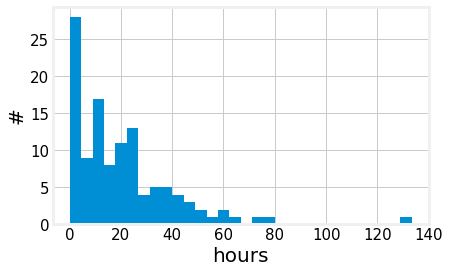

In [3]:
plt.figure(figsize=(6,4))
plt.xlabel("hours",fontsize=20)
plt.ylabel("#",fontsize=20)
plot = df[df.perf == False].hours.hist(bins=30)
plt.savefig("plots/hist_hours.pdf",bbox_inches="tight", pad_inches=0)

In [4]:
# number of experiments over 10 hours
1 - df[df.hours < 10].hours.count()/df[pd.isna(df.hours) == False].hours.count()

0.6551724137931034

In [63]:
df.hours.describe()

count    116.000000
mean      20.470866
std       20.247668
min        0.120833
25%        4.648339
50%       16.300042
75%       26.885559
max      133.342483
Name: hours, dtype: float64

In [6]:
# Total number of hours (in days)
df.hours.sum()/24

98.9425176632625

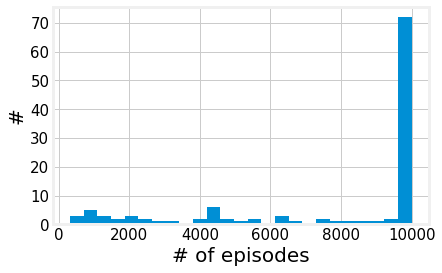

In [5]:
plt.figure(figsize=(6,4))
plt.xlabel("# of episodes",fontsize=20)
plt.ylabel("#",fontsize=20)
df[df.perf == False].n_ep.hist(bins=25)
plt.savefig("plots/hist_n_ep.pdf",bbox_inches="tight", pad_inches=0)

---

# memory plots

In [7]:
import mprof

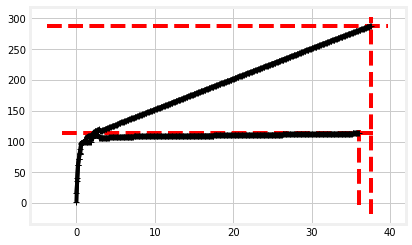

In [24]:
dict_solved = mprof.plot_file("/hdd/Documents/HRL/Memory_test/mprofile_20190729151034.dat")
dict_bad    = mprof.plot_file("/hdd/Documents/HRL/Memory_test/mprofile_20190729150843.dat")

t_solved = [elem - dict_solved['timestamp'][0] for elem in dict_solved['timestamp']]
t_bad    = [elem - dict_bad['timestamp'][0]    for elem in dict_bad['timestamp']]

In [23]:
print(dict.keys())

dict_keys(['mem_usage', 'timestamp', 'func_timestamp', 'filename', 'cmd_line', 'children'])


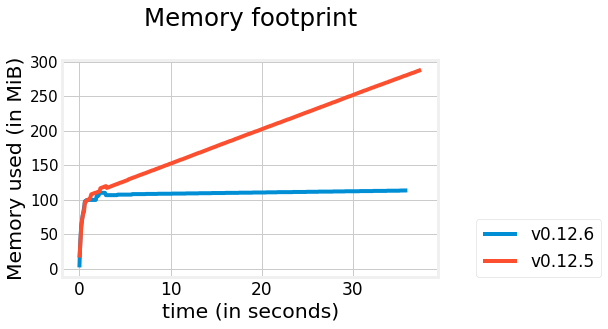

In [62]:
plt.plot(t_solved,dict_solved['mem_usage'],label="v0.12.6")
plt.plot(t_bad   ,dict_bad['mem_usage'],   label="v0.12.5")
plt.ylabel("Memory used (in MiB)")
plt.xlabel("time (in seconds)")
plt.legend(loc=[1.1,0])
plt.title("Memory footprint\n")
plt.savefig("plots/mem_profiler.pdf",bbox_inches="tight", pad_inches=0)

---
# Histogram of actions

In [53]:
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
loader = EventFileLoader("/hdd/Documents/HRL/experiments/198_Nav_new/logs/extra/events.out.tfevents.1563829770.743d94694d36")

wtimes,steps,actions = [],[],[]
for event in loader.Load():
    #set_trace()
    wtime   = event.wall_time
    step    = event.step
    if len(event.summary.value) > 0:
        summary = event.summary.value[0]
        if summary.tag == 'episode/actions':
            wtimes += [wtime]*int(summary.histo.num)
            steps  += [step] *int(summary.histo.num)

            for num,val in zip(summary.histo.bucket,summary.histo.bucket_limit):
                actions += [val] *int(num)

In [70]:
actions = [int(round(a,0)) for a in actions]

In [71]:
len(actions)

44118400

In [72]:
set(actions)

{0, 1, 2, 3, 4}

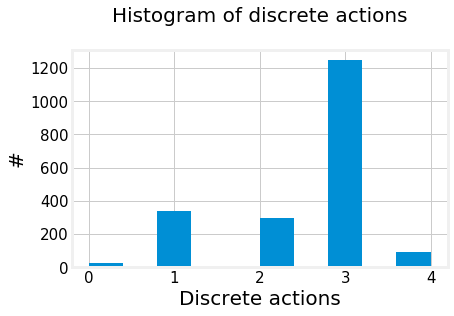

In [87]:
plt.ylabel("#",fontsize=20)
plt.xlabel("Discrete actions",fontsize=20)
plt.title("Histogram of discrete actions\n",fontsize=20)
plt.hist(actions[-2000:])
plt.savefig("plots/hist_actions.pdf",bbox_inches="tight", pad_inches=0)

(array([0.7625, 0.    , 0.655 , 0.    , 0.    , 0.4075, 0.    , 0.3425,
        0.    , 0.3325]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

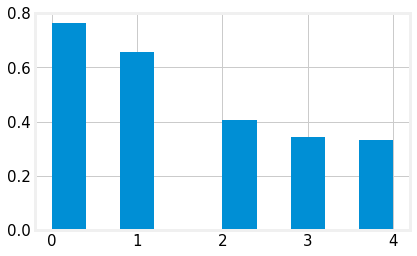

In [76]:
plt.hist(actions[:1000],density=1)

---
# Turn H vs N2N

In [4]:
w_times_a, step_nums_a, vals_a = pickle.load(open('./Turn_n2n_vs_h/n2n_a.pkl','rb'))
w_times_b, step_nums_b, vals_b = pickle.load(open('./Turn_n2n_vs_h/n2n_b.pkl','rb'))
w_times_c, step_nums_c, vals_c = pickle.load(open('./Turn_n2n_vs_h/n2n_c.pkl','rb'))
w_times_d, step_nums_d, vals_d = pickle.load(open('./Turn_n2n_vs_h/n2n_d.pkl','rb'))
w_times_e, step_nums_e, vals_e = pickle.load(open('./Turn_n2n_vs_h/n2n_e.pkl','rb'))
w_times_h_a, step_nums_h_a, vals_h_a = pickle.load(open('./Turn_n2n_vs_h/h_a.pkl','rb'))
w_times_h_b, step_nums_h_b, vals_h_b = pickle.load(open('./Turn_n2n_vs_h/h_b.pkl','rb'))

vals_a_smooth = smooth(vals_a, 0.99)
vals_b_smooth = smooth(vals_b, 0.99)
vals_c_smooth = smooth(vals_c, 0.99)
vals_d_smooth = smooth(vals_d, 0.99)
vals_e_smooth = smooth(vals_e, 0.99)
vals_h_a_smooth = smooth(vals_h_a, 0.99)
vals_h_b_smooth = smooth(vals_h_b, 0.99)

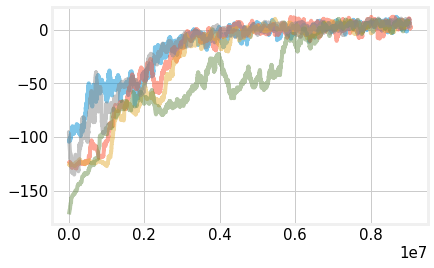

In [11]:
plt.plot(step_nums_a, vals_a_smooth,alpha=0.5)
plt.plot(step_nums_b, vals_b_smooth,alpha=0.5)
plt.plot(step_nums_c, vals_c_smooth,alpha=0.5)
plt.plot(step_nums_d, vals_d_smooth,alpha=0.5)
plt.plot(step_nums_e, vals_e_smooth,alpha=0.5)

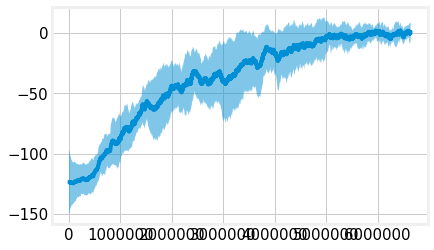

In [42]:
n2n_avg,n2n_std = avg_std(vals_a_smooth,vals_b_smooth,vals_c_smooth,vals_d_smooth,vals_e_smooth)
n2n_stp,_ = avg_std(step_nums_a,step_nums_b,step_nums_c,step_nums_d,step_nums_e)

plt.plot(n2n_stp,n2n_avg)
plt.fill_between(n2n_stp,n2n_avg-n2n_std,n2n_avg+n2n_std,alpha=.5)

---
h

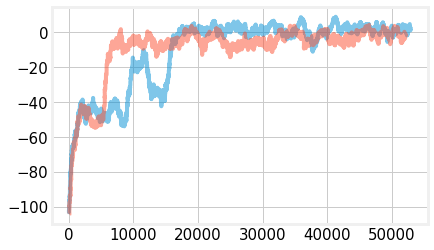

In [44]:
plt.plot(step_nums_h_a, vals_h_a_smooth,alpha=0.5)
plt.plot(step_nums_h_b, vals_h_b_smooth,alpha=0.5)

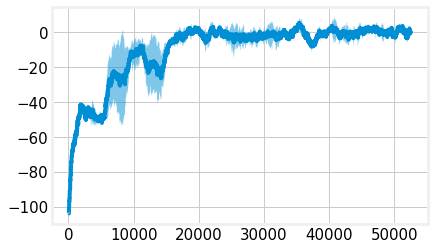

In [47]:
h_avg,h_std = avg_std(vals_h_a_smooth, vals_h_b_smooth)
h_stp,_ = avg_std(step_nums_h_a,step_nums_h_b)

plt.plot(h_stp,h_avg)
plt.fill_between(h_stp,h_avg-h_std,h_avg+h_std,alpha=.5)

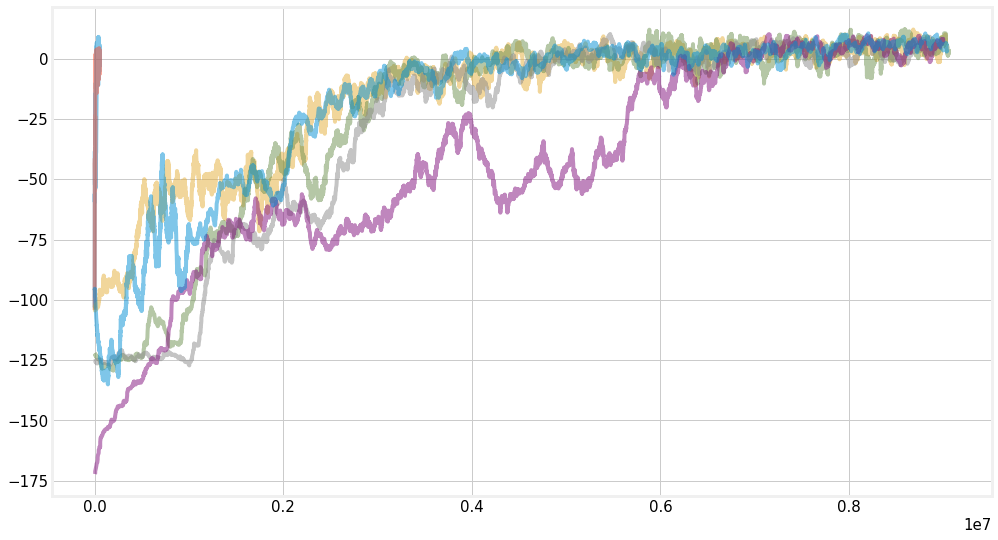

In [7]:
plt.figure(figsize=(15,9))

plt.plot(step_nums_h_a, vals_h_a_smooth,alpha=0.5)
plt.plot(step_nums_h_b, vals_h_b_smooth,alpha=0.5)

plt.plot(step_nums_a, vals_a_smooth,alpha=0.5)
plt.plot(step_nums_b, vals_b_smooth,alpha=0.5)
plt.plot(step_nums_c, vals_c_smooth,alpha=0.5)
plt.plot(step_nums_d, vals_d_smooth,alpha=0.5)
plt.plot(step_nums_e, vals_e_smooth,alpha=0.5)

---
# Nav H vs N2N

In [ ]:
h_nav = EventAccumulator('/Volumes/HDD 1/experiments/110 or 109 /logs/PPO2_1')
h_nav.Reload()
wtimes_h_nav, steps_h_nav, val_h_nav = h_nav.Scalars("episode/episode_reward")